<a href="https://colab.research.google.com/github/xavierhrxs/projetoairbnb/blob/main/LinearNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand
import matplotlib.pyplot as plt

In [2]:
class LineNetwork(nn.Module):
    #Inicialização
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(1,1))

    #Como a rede computa
    def forward(self, x):
        return self.layers(x)

In [3]:
class AlgebraicDataset(Dataset):
    def __init__(self, f, interval, nsamples):
        X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
        self.data = [(x, f(x)) for x in X]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
line = lambda x: 2*x + 3
interval = (-10, 10)
train_nsamples = 1000
test_nsamples = 100

train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cpu


In [6]:
model = LineNetwork().to(device)


In [7]:
# Loss Function
# MSE Mean Square Error
lossfunc = nn.MSELoss()

#Stochastic Gradient Descent
#lr learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)



In [8]:
def train(model, dataloader, lossfunc, optimizer):
    model.train()

    cumloss = 0.0

    for X, y in dataloader:
        X = X.unsqueeze(1).float().to(device)
        y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    #zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda, de fato, na direção que reduz o erro local
    optimizer.step()
    # loss é um tensor; item pra obter o float
    cumloss += loss.item()

    return cumloss/len(dataloader)

def test(model, dataloader, lossfunc):
    model.eval()
    cumloss = 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.unsqueeze(1).float().to(device)
            y = y.unsqueeze(1).float().to(device)

        pred = model(X)
        loss = lossfunc(pred, y)
        cumloss += loss.item()

    return cumloss/len(dataloader)

In [9]:
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.grid(True, which='both')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    samples = np.linspace(interval[0], interval[1], nsamples)
    model.eval()
    with torch.no_grad():
        pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

    ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
    ax.plot(samples, pred.cpu(), label="model")
    plt.legend()
    plt.show()

Epoch: 0; Train Loss: 167.0095977783203


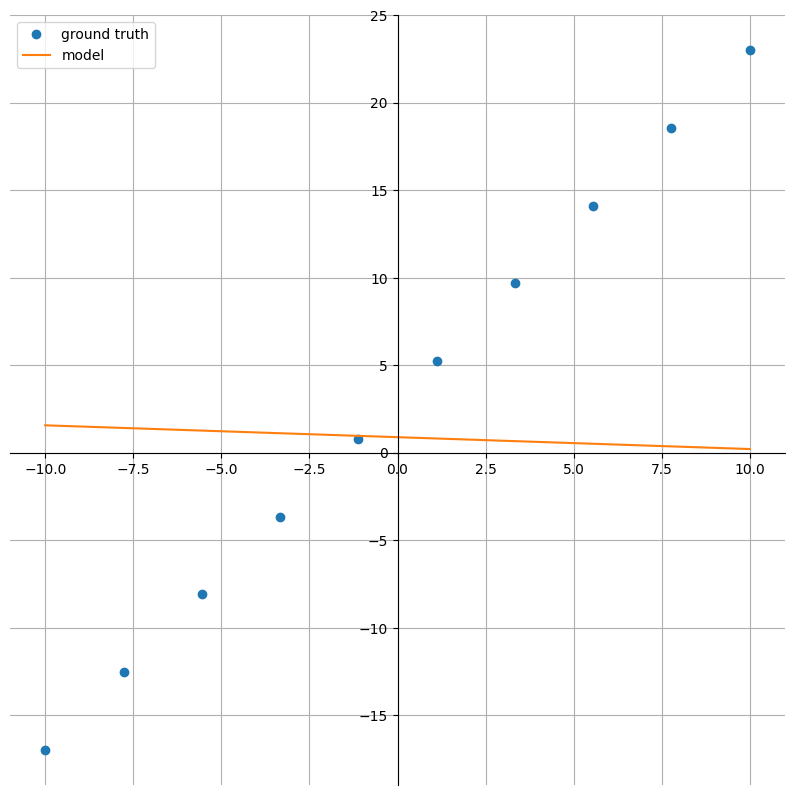

Epoch: 10; Train Loss: 44.118499755859375


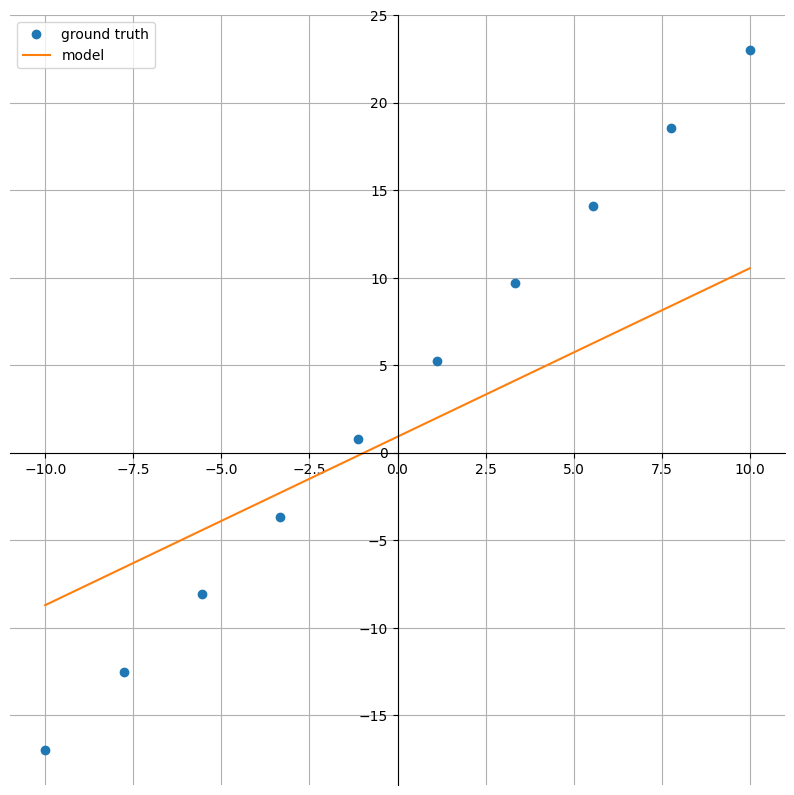

Epoch: 20; Train Loss: 13.966171264648438


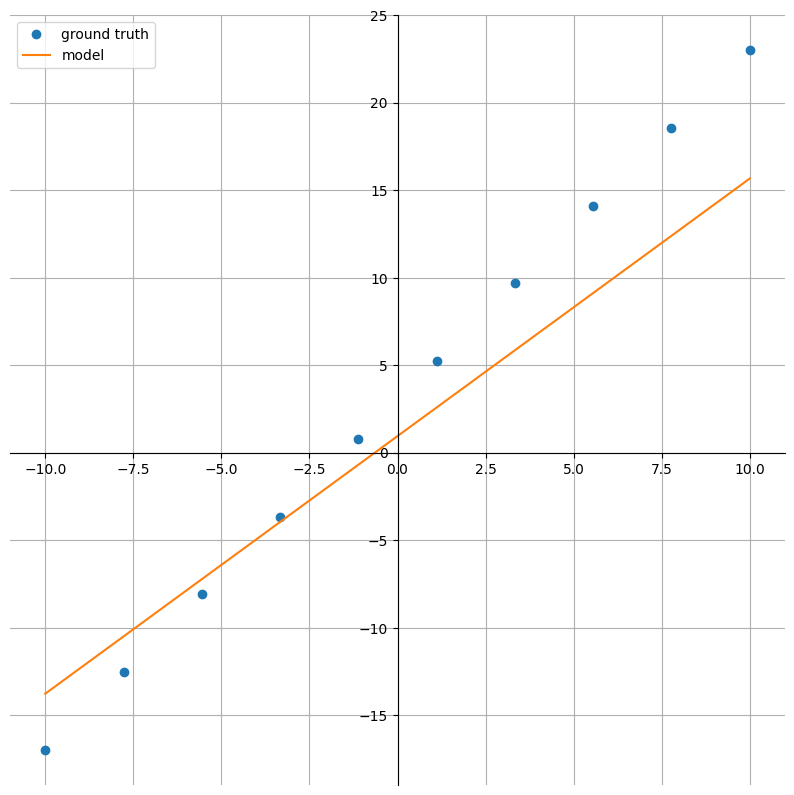

Epoch: 30; Train Loss: 6.475533962249756


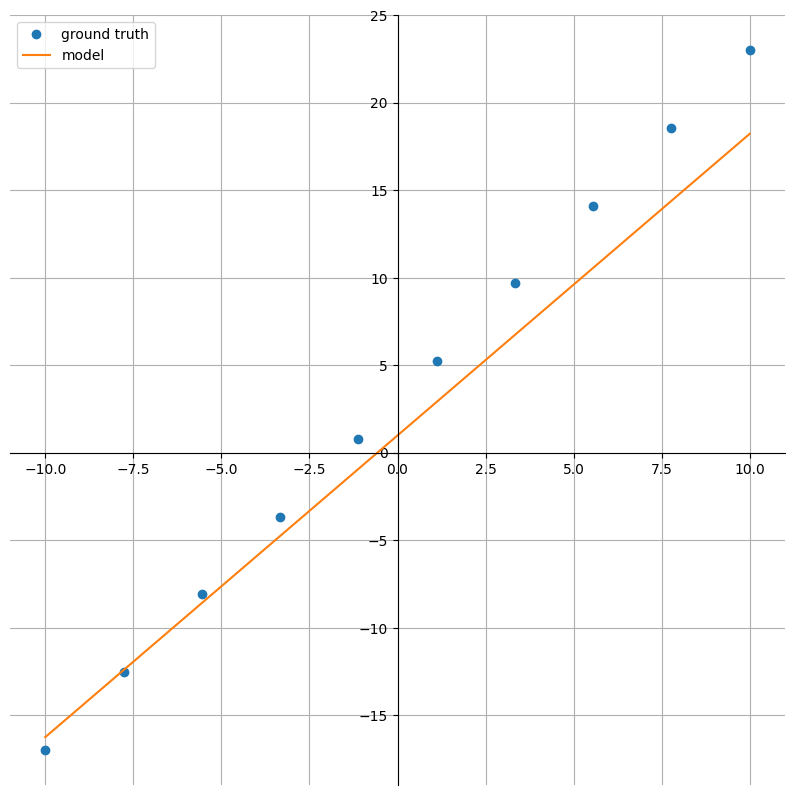

Epoch: 40; Train Loss: 4.5261406898498535


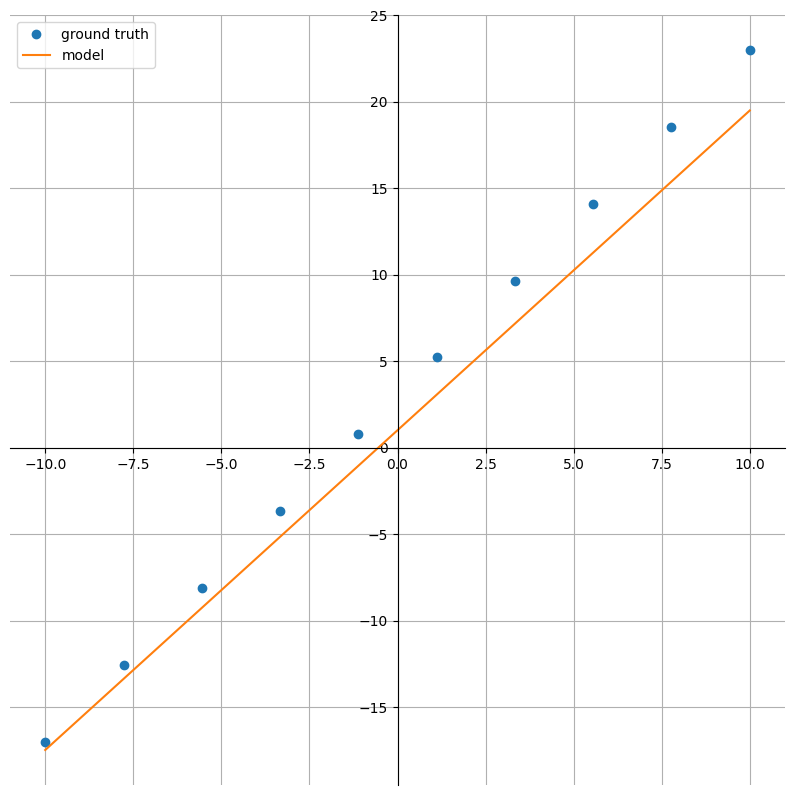

Epoch: 50; Train Loss: 3.935159921646118


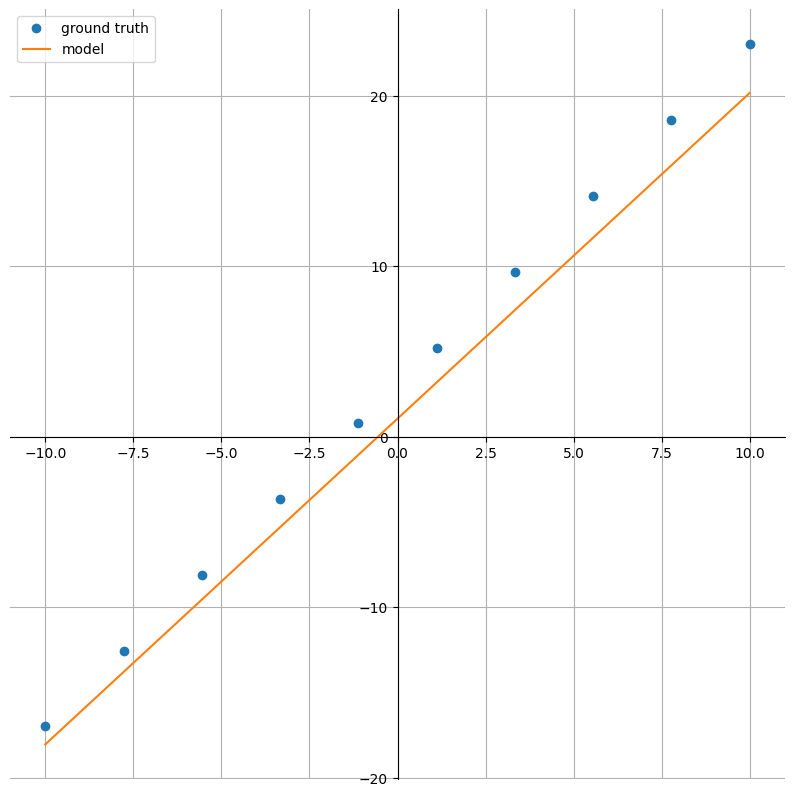

Epoch: 60; Train Loss: 3.68051815032959


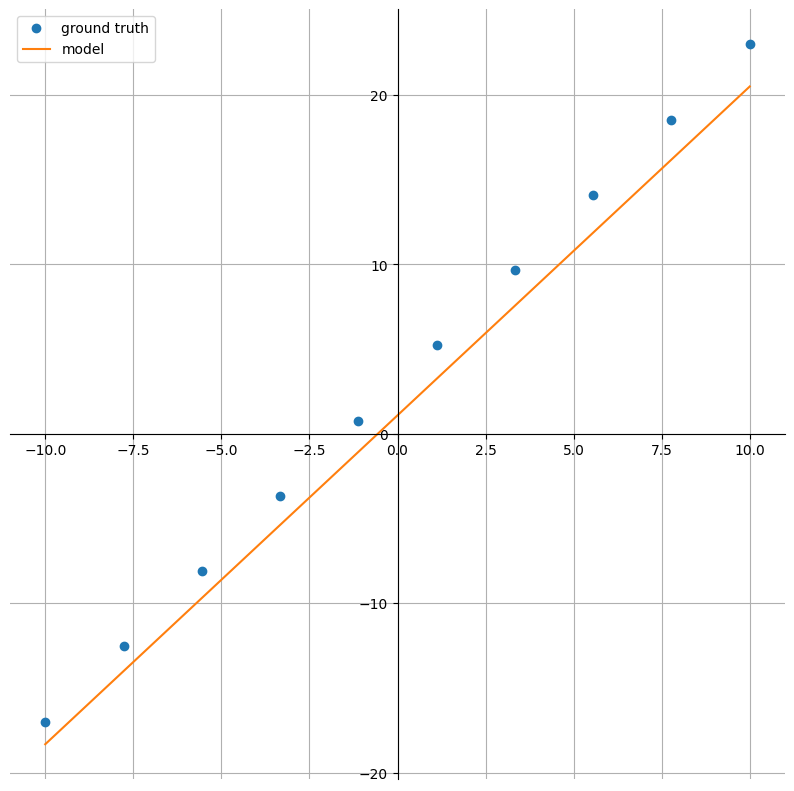

Epoch: 70; Train Loss: 3.5123424530029297


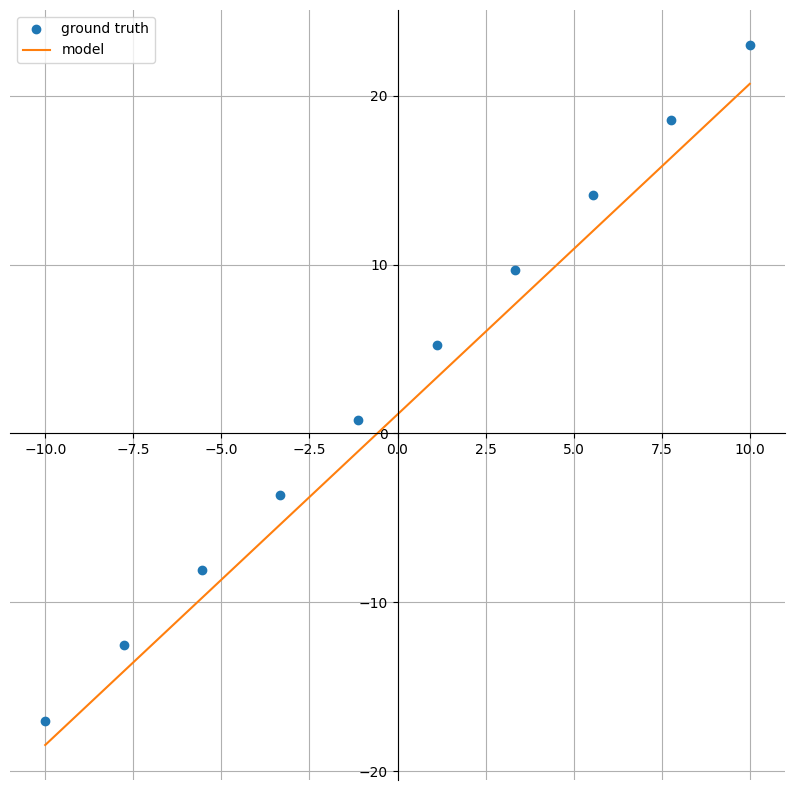

Epoch: 80; Train Loss: 3.3694214820861816


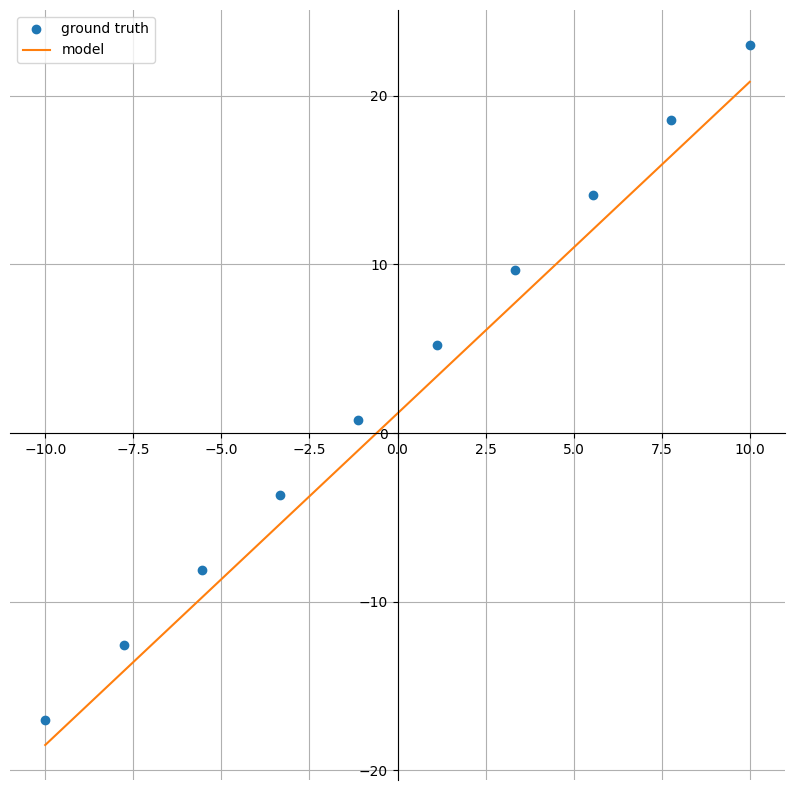

Epoch: 90; Train Loss: 3.2366392612457275


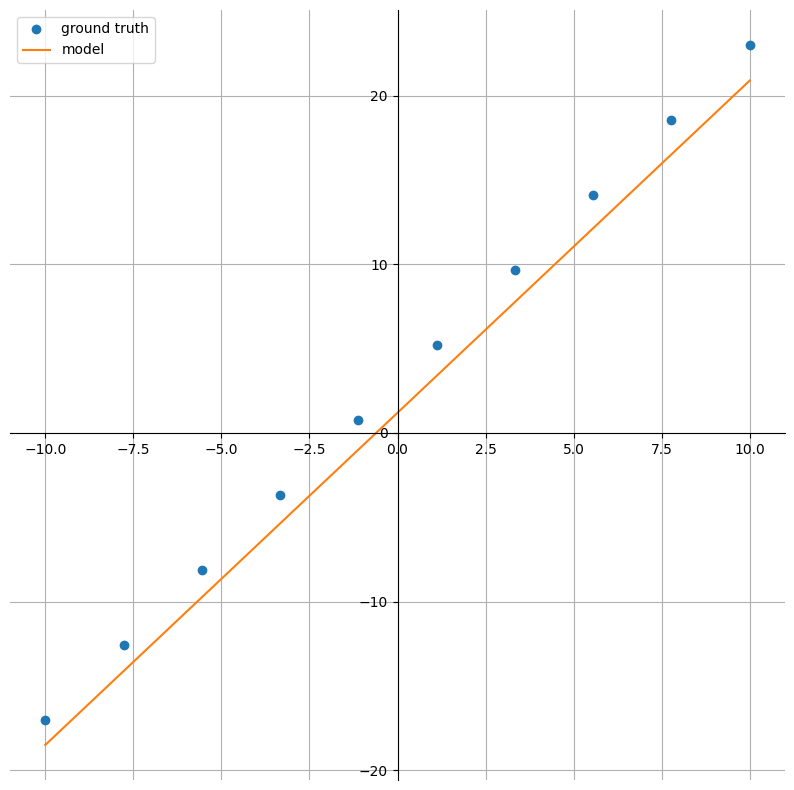

Epoch: 100; Train Loss: 3.1101460456848145


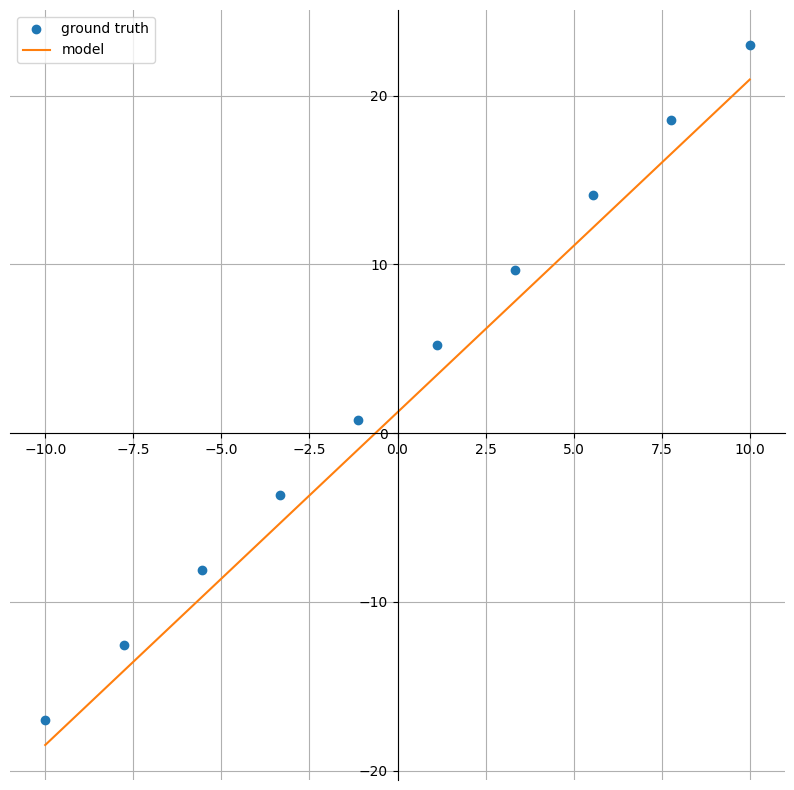

Test Loss: 3.1883206367492676


In [10]:
epochs = 101
for t in range(epochs):
    train_loss = train(model, train_dataloader, lossfunc, optimizer)
    if t % 10 == 0:
        print(f"Epoch: {t}; Train Loss: {train_loss}")
        plot_comparinson(line, model)
test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")